In [ ]:
import pickle
import unicodedata
import regex as re
import numpy as np
import unicodedata
import regex as re
import matplotlib.pyplot as plt
import random
import math
from tensorflow.keras.models import Model
import pandas as pd
from google.colab import drive
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding,LSTM,Dense,Softmax

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Creating data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/data_500k.csv")
df = df.dropna()
df.rename(columns = {'original':'correct',"modified":"wrong"}, inplace = True)
df.head()

,correct,wrong
0,they do not,they due not
1,they do to,they do too
2,i hope so,i hope so
3,she okay,she okay
4,let's go,let's go


## 2. Distribution of length of sentences

In [ ]:
corr_lengths = df['correct'].str.split().apply(len)
wrng_lengths = df['wrong'].str.split().apply(len)


for i in range(0,101,10):
    print(i,np.percentile(corr_lengths, i))
for i in range(90,101):
    print(i,np.percentile(corr_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(corr_lengths, i))

0 1.0
10 4.0
20 5.0
30 6.0
40 8.0
50 10.0
60 12.0
70 15.0
80 19.0
90 27.0
100 552.0
90 27.0
91 29.0
92 30.0
93 32.0
94 34.0
95 37.0
96 40.0
97 45.0
98 51.0
99 65.0
100 552.0
99.1 67.0
99.2 69.0
99.3 73.0
99.4 76.0
99.5 80.0
99.6 86.0
99.7 93.0
99.8 104.0
99.9 124.0
100 552.0


> <font color="blue"><b>We observe the values, 99.2% of the data points are having length &lt; 70, so select the sentences that have words &lt; 70 </b> </font>

In [ ]:
max_length = 70

## 3. Preparing data for ENCODER DECODER

In [ ]:
df['wrng_lengths'] = df['wrong'].str.split().apply(len)
df = df[df['wrng_lengths'] < 70]

df['corr_lengths'] = df['correct'].str.split().apply(len)
df = df[df['corr_lengths'] < 70]

df['corr_inp'] = '<start> ' + df['correct'].astype(str)
df['corr_out'] = df['correct'].astype(str) + ' <end>'

df = df.drop(['correct','corr_lengths','wrng_lengths'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,wrong,corr_inp,corr_out
0,they due not,<start> they do not,they do not <end>
1,they do too,<start> they do to,they do to <end>
2,i hope so,<start> i hope so,i hope so <end>
3,she okay,<start> she okay,she okay <end>
4,let's go,<start> let's go,let's go <end>


##4. Getting train and test 

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(df, test_size=0.2)

In [ ]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['corr_inp']= str(train.iloc[0]['corr_inp'])+' <end>'
train.iloc[0]['corr_out']= str(train.iloc[0]['corr_out'])+' <end>'

(481389, 3) (120348, 3)


In [ ]:
train.head()

,wrong,corr_inp,corr_out
47054,she did a harriman,<start> she did a harriman <end>,she did a harriman <end> <end>
162063,i hate to conduct business on the lanai why do...,<start> i hate to conduct business on the lana...,i hate to conduct business on the lanai why do...
76251,christmastime,<start> christmastime,christmastime <end>
200506,i got trapped and you no it sew let's halve su...,<start> i got trapped and you know it so let's...,i got trapped and you know it so let's have so...
398929,he is fine and we know the jokes when it gets ...,<start> he is fine and we know the jokes when...,he is fine and we know the jokes when it gets...


In [ ]:
validation.head()

,wrong,corr_inp,corr_out
78393,that's fine stella now would you make me a san...,<start> that's fine stella now would you make ...,that's fine stella now would you make me a san...
605826,aye know what you're thinking you'd be a lot s...,<start> i know what you're thinking you'd be ...,i know what you're thinking you'd be a lot sa...
479401,you chews these,<start> you choose these,you choose these <end>
398034,you knowlike restaurants night clubs,<start> you knowlike restaurants night clubs,you knowlike restaurants night clubs <end>
102596,take good look around there's nobody in this p...,<start> take a good look around there's nobody...,take a good look around there's nobody in this...


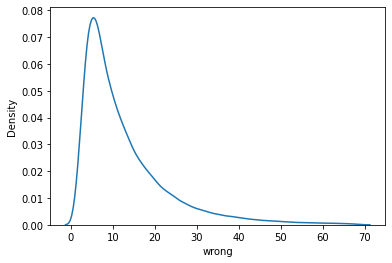

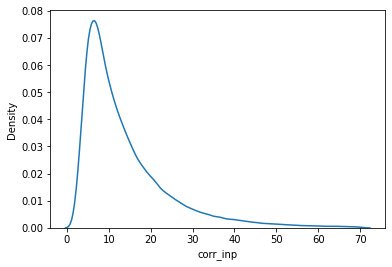

In [ ]:
wrng_lengths = train['wrong'].str.split().apply(len)
corr_lenths = train['corr_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(wrng_lengths)
plt.show()
sns.kdeplot(corr_lenths)
plt.show()

Observations:

1. We see majority of the sentences contains 0-40 words.
2. We have ignored sentences with length more than 70.

## 5.Tokenization of data

In [ ]:
tknizer_wrng = Tokenizer()
tknizer_wrng.fit_on_texts(train['wrong'].values)


tknizer_corr = Tokenizer(filters='\t\n')
tknizer_corr.fit_on_texts(train['corr_inp'].values)

In [ ]:
vocab_size_wrng=len(tknizer_wrng.word_index.keys())
print(vocab_size_wrng)
vocab_size_corr=len(tknizer_corr.word_index.keys())
print(vocab_size_corr)

65901
65713


In [ ]:
tknizer_corr.word_index['<start>'], tknizer_corr.word_index['<end>']

(1, 57429)

In [ ]:
# saving
with open('/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/BACKUP DATA/tokenizer_wrong.pickle', 'wb') as handle:
    pickle.dump(tknizer_wrng, handle, protocol=pickle.HIGHEST_PROTOCOL)

# saving
with open('/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/BACKUP DATA/tokenizer_correct.pickle', 'wb') as handle:
    pickle.dump(tknizer_corr, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 6.Creating embeddings for english sentences

In [ ]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2022-11-09 16:19:01--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2022-11-09 16:19:01--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc520f0e5c42d41c23461b15dd3f.dl.dropboxusercontent.com/cd/0/inline/BwZenmKaFvsj4Sz7FfwDpLjNhAwgEqINh_Y4pPfPQxywh560ua3FWMT185xjR5odZ0hC_1A6dW9XrtMF2Zx9gFsuySVkXG9Ig98fV_SojrBKFpPcKiYHEQEq0ZdHScnBMXDteeeFgwLykWOr5k7IaajVfy3anwZ22N3mA9I0prWfDw/file# [following]
--2022-11-09 16:19:02--  https://uc520f0e5c42d41c23461b15dd3f.dl.dropboxusercontent.com/cd/0/inline/BwZenmKaFvsj4Sz7FfwDpLjNhAwgEqINh_Y4pPfPQxywh560ua3FWMT185xjR5odZ

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix_enc = np.zeros((vocab_size_wrng+1, 100))
for word, i in tknizer_wrng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_enc[i] = embedding_vector



embedding_matrix_dec = np.zeros((vocab_size_corr+1, 100))
for word, i in tknizer_corr.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_dec[i] = embedding_vector

##7. <font color='blue'>**Implement custom encoder decoder**</font>

### 7.1 Creating Encoder and Decoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, enc_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = 100
        self.input_length = input_length
        self.enc_units= enc_units
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        
    def build(self, input_shape):
        # self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
        #                    mask_zero=True, name="embedding_layer_encoder")
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder", weights=[embedding_matrix_enc], trainable=False)
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM")
        
    def call(self, input_sentances, training=True):
        input_embedd                           = self.embedding(input_sentances)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c
    def get_states(self):
        return self.lstm_state_h,self.lstm_state_c
    
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, dec_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = 100
        self.dec_units = dec_units
        self.input_length = input_length
        # we are using embedding_matrix and not training the embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder", weights=[embedding_matrix_dec], trainable=False)
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Encoder_LSTM")
    
    def call(self, target_sentances, state_h, state_c):
        target_embedd           = self.embedding(target_sentances)
        lstm_output, state_h, state_c     = self.lstm(target_embedd, initial_state=[state_h, state_c])
        return lstm_output, state_h, state_c

### 7.2 Creating data pipeline

In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['wrong'].values
        self.decoder_inps = data['corr_inp'].values
        self.decoder_outs = data['corr_out'].values
        self.wrng_tokenizer = tknizer_wrng
        self.corr_tokenizer = tknizer_corr
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.wrng_tokenizer.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.corr_tokenizer.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.corr_tokenizer.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train.isna().sum()

wrong       0
corr_inp    0
corr_out    0
dtype: int64

### 7.3 Defining the Model class

In [ ]:
# this is the same model we have given in the other reference notebook
class MyModel(Model):
    def __init__(self, encoder_inputs_length,decoder_inputs_length, output_vocab_size):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.encoder = Encoder(vocab_size=vocab_size_wrng +1, embedding_dim=30, input_length=encoder_inputs_length, enc_units=512)
        self.decoder = Decoder(vocab_size=vocab_size_corr+1, embedding_dim=30, input_length=decoder_inputs_length, dec_units=512)
        self.dense   = Dense(output_vocab_size, activation='softmax')
        
        
    def call(self, data):
        input,output = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(input)
        decoder_output,_,_                 = self.decoder(output, encoder_h, encoder_c)
        output                               = self.dense(decoder_output)
        return output

### 7.4 Model training

In [ ]:
print(train.shape)
print(validation.shape)

(481389, 3)
(120348, 3)


In [ ]:
# max_length = 70

In [ ]:
train_dataset = Dataset(train[:400000], tknizer_wrng, tknizer_corr, max_length)
test_dataset  = Dataset(validation[:25000], tknizer_wrng, tknizer_corr, max_length)

train_dataloader = Dataloder(train_dataset, batch_size=128)
test_dataloader = Dataloder(test_dataset, batch_size=128)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)
print(test_dataloader[0][0][0].shape, test_dataloader[0][0][1].shape, test_dataloader[0][1].shape)

(128, 70) (128, 70) (128, 70)
(128, 70) (128, 70) (128, 70)


In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/MODELS"+'/best_end_decoder_final_units_512.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_loss',verbose = 1),
    tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0.01, patience=1, verbose=1,  mode='auto',  baseline=None,  restore_best_weights=True)
]

In [ ]:
model1  = MyModel(encoder_inputs_length=max_length,decoder_inputs_length=max_length,output_vocab_size=vocab_size_corr)
optimizer = tf.keras.optimizers.Adam()
model1.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
history = model1.fit(train_dataloader, epochs=30, validation_data=test_dataloader,callbacks = callbacks)
model1.summary()

Epoch 1/30
3125/3125 [==============================] - ETA: 0s - loss: 0.9100
Epoch 1: val_loss improved from inf to 0.58646, saving model to /content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/MODELS/best_end_decoder_final_units_512.h5
3125/3125 [==============================] - 264s 82ms/step - loss: 0.9100 - val_loss: 0.5865
Epoch 2/30
3125/3125 [==============================] - ETA: 0s - loss: 0.4568
Epoch 2: val_loss improved from 0.58646 to 0.38184, saving model to /content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/MODELS/best_end_decoder_final_units_512.h5
3125/3125 [==============================] - 256s 82ms/step - loss: 0.4568 - val_loss: 0.3818
Epoch 3/30
3125/3125 [==============================] - ETA: 0s - loss: 0.3046
Epoch 3: val_loss improved from 0.38184 to 0.29502, saving model to /content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/MODELS/best_end_decoder_final_units_512.h5
3125/3125 [==============================] - 257s 82ms/step - loss: 0.3046 - val_loss: 0.2950
Epoch

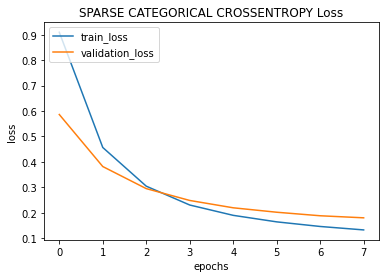

In [ ]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('SPARSE CATEGORICAL CROSSENTROPY Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'validation_loss'], loc='upper left')
plt.show()

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model1.save('/content/drive/MyDrive/DATA SCIENCE/CASE STUDY 2/MODELS/saved_model/FINAL_ENCOEDER_DECODER_units_512') 

## 8. PREDICT

In [ ]:
print( model1.layers[0] )

In [ ]:
#defining predict func

def predict( input_sentence ) :
  
    inp = tknizer_wrng.texts_to_sequences ( [ input_sentence ] )
    inp  = pad_sequences ( inp , maxlen = vocab_size_wrng , dtype = 'int32' , padding = 'post' )
    # print( inp.shape )   
    enc_out , enc_h_state , enc_c_state = model1.layers[ 0 ] ( inp )
    


    dec_inp = np.array ( tknizer_corr.word_index ['<start>'] ).reshape( 1 , 1 )   
    dec_stop = tknizer_corr.word_index ['<end>']
    
    
    states = [ enc_h_state , enc_c_state ] 
    stop_condition = False
    
    
    sent = ''
    k = 0

    while not stop_condition :
        
        
        
        predicted_out , enc_h_state , enc_c_state = model1.layers[ 1 ] ( dec_inp , enc_h_state, enc_c_state )
        
        #pred prbablities
        
        
        pred_proba = model1.layers [ 2 ] ( predicted_out )
        
        
        

        word_ind = np.argmax ( pred_proba , -1 )
        pred_str = list ( tknizer_corr.word_index.keys( ) ) [ int ( word_ind - 1 ) ]
        sent += ' '+pred_str
        
        
        k += 1
        
        
        #if conditions based on word length
        
        if k > 130 or int ( word_ind ) == int ( dec_stop ) :
            
            
            stop_condition = True
            
        dec_inp = word_ind.reshape ( 1 , 1 )
        
        
    #returining sent ans state h#
    
    return sent , enc_h_state , enc_c_state




In [ ]:
validation['wrong' ].values[ 1010 ] , validation[ "corr_out" ].values[ 1010 ]

("no can ewe drive me home i'll bring ewe back in the morning ",
 "no  can you drive me home  i'll bring you back in the morning <end>")

In [ ]:
#defining start time and end time

pred_sent , enc_output , dec_hid  = predict ( validation['wrong'].values[ 1010 ] )
pred_sent



" no can you drive me home i'll bring you back in the morning <end>"

In [ ]:
test_data_sentences = list(train['wrong'])
test_data_sentences_output = list(train['corr_out'])

In [ ]:
import random
from tqdm import tqdm
indexes = random.sample(range(0, 111499), 1000)
sentences_test = []
sentences_test_output = []
sentences_test_pred = []
for each in tqdm(indexes):

  sentences_test.append(test_data_sentences[each])
  sentences_test_output.append(test_data_sentences_output[each])
  ans,_,_ = predict(test_data_sentences[each])
  sentences_test_pred.append(ans)

100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]


In [ ]:
print(sentences_test[2])
print(sentences_test_output[2])
print(sentences_test_pred[2])

we need blood two nourish the stone charge the stone with ener gy 
we need blood  to nourish the stone  charge the stone with ener gy <end>
 we need blood to nourish the stone of the sharon once with zowie <end>


## 9. Calculating BLEU Score

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import nltk.translate.bleu_score as bleu
total_score = 0


for i in tqdm(range(len(sentences_test_output))):
  reference = [sentences_test_output[i].split(),] # the original
  translation = sentences_test_pred[i].split()# trasilated using model
  total_score += bleu.sentence_bleu(reference, translation)

avg_score = total_score/1000
print("\navg_score",avg_score)

100%|██████████| 1000/1000 [00:00<00:00, 6483.15it/s]


avg_score 0.7131995131856474
